<h1 style="font-size:3rem;color:orange;">Predicting Loan E-Signatures 🖆</h1>

<h2 style="font-size:2rem;color:orange;">Data Pre-processing and Model Building</h2>

### Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
import warnings

# Optionally surpress warnings from libraries due to changes in the Python ecosystem
warnings.filterwarnings(action='ignore', module='_distutils_hack', category=UserWarning)
warnings.filterwarnings(action='ignore', module='setuptools', category=UserWarning)
warnings.filterwarnings("ignore", message="savefig.jpeg_quality is deprecated")

### Import Data

In [3]:
df_users_financial = pd.read_csv("../data/processed/new_P39-Financial-Data.csv")

### Data Peek 👀

In [4]:
df_users_financial.head()

,entry_id,age,monthly_income,years_employed,current_address_year,amount_requested,risk_score,inquiries_last_month,pay_schedule,home_owner,has_debt,personal_account_months,avg_risk_score,avg_ext_quality_score,e_signed
0,7629673,40,3135,3,3,550,36200,10,bi-weekly,1,1,30,0.661151,0.480918,1
1,3560428,61,3180,6,3,600,30150,9,weekly,0,1,86,0.789841,0.680720,0
2,6934997,23,1540,0,0,450,34550,7,weekly,0,1,19,0.691712,0.531712,0
3,5682812,40,5230,6,1,700,42150,8,bi-weekly,0,1,86,0.793179,0.692552,1
4,5335819,33,3590,5,2,1100,53850,12,semi-monthly,0,1,98,0.688483,0.744634,0


In [5]:
df_users_financial.describe()

,entry_id,age,monthly_income,years_employed,current_address_year,amount_requested,risk_score,inquiries_last_month,home_owner,has_debt,personal_account_months,avg_risk_score,avg_ext_quality_score,e_signed
count,1.790800e+04,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000
mean,5.596978e+06,43.015412,3657.214653,3.526860,3.584711,950.446449,61086.302211,6.457226,0.425173,0.795399,45.467389,0.717640,0.622590,0.538251
std,2.562473e+06,11.873107,1504.890063,2.259732,2.751937,698.543683,15394.255020,3.673093,0.494383,0.403421,23.258829,0.070536,0.115284,0.498549
min,1.111398e+06,18.000000,905.000000,0.000000,0.000000,350.000000,2100.000000,1.000000,0.000000,0.000000,0.000000,0.353661,0.022057,0.000000
25%,3.378999e+06,34.000000,2580.000000,2.000000,2.000000,600.000000,49350.000000,4.000000,0.000000,1.000000,29.000000,0.668689,0.547725,0.000000
50%,5.608376e+06,42.000000,3260.000000,3.000000,3.000000,700.000000,61200.000000,6.000000,0.000000,1.000000,40.000000,0.719793,0.627009,1.000000
75%,7.805624e+06,51.000000,4670.000000,5.000000,5.000000,1100.000000,72750.000000,8.000000,1.000000,1.000000,54.000000,0.769095,0.702689,1.000000
max,9.999874e+06,96.000000,9985.000000,16.000000,12.000000,10200.000000,99750.000000,30.000000,1.000000,1.000000,183.000000,0.925252,0.966953,1.000000


- Above we note that we currently have 17,908 samples for model training
- With 12 numerical & categorical features

# Data Pre-processing 🧹

### Remove the label from the features

In [6]:
label = df_users_financial['e_signed']
df_users_financial = df_users_financial.drop(columns = 'e_signed')

### One-Hot Encoding 

In [7]:
# One-hot encoding of 'pay_schedule'
df_users_financial_ohe = pd.get_dummies(df_users_financial)

### Transformations

In [8]:
# Take the log of amount_requested to address skew
df_users_financial_ohe['log_amount_requested'] = np.log(df_users_financial_ohe['amount_requested'])

# Drop the previous values 
df_users_financial_ohe.drop('amount_requested', axis=1, inplace=True)

### Feature Scaling

In [9]:
from sklearn.preprocessing import StandardScaler

# Identify columns to be excluded from scaling
excluded_columns = [col for col in df_users_financial_ohe.columns if any(substring in col for substring in ['pay_schedule_', 'has_', 'home_'])]

# Columns to be standardized
columns_to_scale = [col for col in df_users_financial_ohe.columns if col not in excluded_columns]

# Instantiate the scaler
standard_scaler_X = StandardScaler()

# Scale the non-binary columns
scaled_features = standard_scaler_X.fit_transform(df_users_financial_ohe[columns_to_scale])

# Convert scaled features into DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=columns_to_scale, index=df_users_financial_ohe.index)

# Concatenate the scaled features with the binary columns to get the final dataframe
features_df = pd.concat([scaled_df, df_users_financial_ohe[excluded_columns]], axis=1)

features_df.head()

,entry_id,age,monthly_income,years_employed,current_address_year,risk_score,inquiries_last_month,personal_account_months,avg_risk_score,avg_ext_quality_score,log_amount_requested,home_owner,has_debt,pay_schedule_bi-weekly,pay_schedule_monthly,pay_schedule_semi-monthly,pay_schedule_weekly
0,0.793278,-0.253977,-0.347022,-0.233158,-0.212478,-1.616642,0.964548,-0.665030,-0.800871,-1.228936,-0.725565,1,1,True,False,False,False
1,-0.794782,1.514775,-0.317118,1.094470,-0.212478,-2.009657,0.692290,1.742725,1.023625,0.504246,-0.560629,0,1,False,False,False,True
2,0.522174,-1.685824,-1.406929,-1.560786,-1.302650,-1.723828,0.147774,-1.137982,-0.367592,-0.788324,-1.105950,0,1,False,False,False,True
3,0.033498,-0.253977,1.045146,1.094470,-0.939260,-1.230123,0.420032,1.742725,1.070952,0.606882,-0.268425,0,1,True,False,False,False
4,-0.101919,-0.843561,-0.044665,0.651928,-0.575869,-0.470078,1.509063,2.258672,-0.413376,1.058668,0.588344,0,1,False,False,True,False


### Split the dataset into training and test sets

In [10]:
from sklearn.model_selection import train_test_split

# Split the data into an 80/20 train/test ratio
X_train, X_test, y_train, y_test = train_test_split(features_df, label, test_size = 0.2, random_state = 42)

print(X_train.shape)
print(X_test.shape)

(14326, 17)
(3582, 17)


### Filter model data

In [11]:
# Purge user identification, persist to associate the prediction to the user it came from 
user_identification = 'entry_id'

train_identifier = X_train[user_identification]
X_train = X_train.drop(columns = [user_identification])

test_identifier = X_test[user_identification]
X_test = X_test.drop(columns = [user_identification])

# Model Building 🤖

### Training Data

In [12]:
# Split the training set into a 80/20 training/validation set
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

print(X_train.shape)
print(X_validation.shape)

(11460, 16)
(2866, 16)


### Metrics Function

In [13]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def evaluate_scores_and_concat(y_test, y_predict, model_name, results_dataframe): 
    """
    Evaluates model scores and concatenates results to a DataFrame.
    """
    # Get scores
    accuracy = accuracy_score(y_test, y_predict)   # CorrectPredicts / TotalPredicts  
    precision = precision_score(y_test, y_predict) # TP / (TP+FP)
    recall = recall_score(y_test, y_predict)       # TP / (TP+FN)
    f1 = f1_score(y_test, y_predict)               # 2*(precision*recall) / (precision+recall)
    
    # Transfer scores to a DataFrame
    new_results = pd.DataFrame([[model_name, accuracy, precision, recall, f1]],
            columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])
    
    # Concatenate results to the results_dataframe vertically
    results_dataframe = pd.concat([results_dataframe, new_results], axis=0).reset_index(drop=True)
    
    return results_dataframe

## Logistic Regression

### Training

In [14]:
from sklearn.linear_model import LogisticRegression

# Add 'l1' penalty (lasso regularization)
model = LogisticRegression(penalty='l1', solver='saga', random_state=42)

# Train the model on the training set
model.fit(X_train, y_train)

LogisticRegression(penalty='l1', random_state=42, solver='saga')

### Evaluation

In [15]:
# Make model predictions from the validation set
y_predict = model.predict(X_validation)

# Initialize a results DataFrame
df_results = pd.DataFrame()

# Get model scores
df_results = evaluate_scores_and_concat(y_validation, y_predict, 'Logistic Regression (Lasso)', df_results)

# Display
df_results.head()

,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression (Lasso),0.58374,0.593817,0.721036,0.651272


## Support Vector Classification

### SVC (Linear) Training

In [16]:
from sklearn.svm import SVC

# Add linear kernel
model = SVC(kernel='linear', random_state=42)

# Train the model on the training set
model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

### SVC (Linear) Evaluation

In [17]:
# Make model predictions from the validation set
y_predict = model.predict(X_validation)

# Get model scores
df_results = evaluate_scores_and_concat(y_validation, y_predict, 'SVC (Linear)', df_results)

# Display
df_results

,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression (Lasso),0.583740,0.593817,0.721036,0.651272
1,SVC (Linear),0.588276,0.595500,0.736570,0.658565


### SVC (RBF) Training

In [18]:
# Radial Basis Function kernel (default)
model = SVC(kernel='rbf', random_state=42)

# Train the model on the training set
model.fit(X_train, y_train)

SVC(random_state=42)

### SVC (RBF) Evaluation

In [19]:
# Make model predictions from the validation set
y_predict = model.predict(X_validation)

# Get model scores
df_results = evaluate_scores_and_concat(y_validation, y_predict, 'SVC (RBF)', df_results)

# Display
df_results

,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression (Lasso),0.583740,0.593817,0.721036,0.651272
1,SVC (Linear),0.588276,0.595500,0.736570,0.658565
2,SVC (RBF),0.609211,0.616822,0.726214,0.667063


## Random Forest Classifier

### Training

In [20]:
from sklearn.ensemble import RandomForestClassifier

# 100 trees
model = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=42)

# Train the model on the training set
model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', random_state=42)

### Evaluation

In [21]:
# Make model predictions from the validation set
y_predict = model.predict(X_validation)

# Get model scores
df_results = evaluate_scores_and_concat(y_validation, y_predict, 'Random Forest Classifier (n=100)', df_results)

# Display
df_results

,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression (Lasso),0.583740,0.593817,0.721036,0.651272
1,SVC (Linear),0.588276,0.595500,0.736570,0.658565
2,SVC (RBF),0.609211,0.616822,0.726214,0.667063
3,Random Forest Classifier (n=100),0.624215,0.645161,0.673139,0.658853


## XGBoost Classifier

### Training

In [22]:
from xgboost import XGBClassifier

# 100 stages (trees)
model = XGBClassifier(n_estimators=100, objective='binary:logistic', random_state=42)

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

### Evaluation

In [23]:
# Make model predictions from the validation set
y_predict = model.predict(X_validation)

# Get model scores
df_results = evaluate_scores_and_concat(y_validation, y_predict, 'XGBoost Classifier (n=100)', df_results)

# Display
df_results

,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression (Lasso),0.583740,0.593817,0.721036,0.651272
1,SVC (Linear),0.588276,0.595500,0.736570,0.658565
2,SVC (RBF),0.609211,0.616822,0.726214,0.667063
3,Random Forest Classifier (n=100),0.624215,0.645161,0.673139,0.658853
4,XGBoost Classifier (n=100),0.637125,0.658307,0.679612,0.668790


## Gradient Boosting Classifier

### Training

In [24]:
from sklearn.ensemble import GradientBoostingClassifier 

# 100 stages (trees)
model = GradientBoostingClassifier(n_estimators=100, random_state=42)

model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

### Evaluation

In [25]:
# Make model predictions from the validation set
y_predict = model.predict(X_validation)

# Get model scores
df_results = evaluate_scores_and_concat(y_validation, y_predict, 'Gradient Boosting Classifier (n=100)', df_results)

# Display
df_results

,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression (Lasso),0.583740,0.593817,0.721036,0.651272
1,SVC (Linear),0.588276,0.595500,0.736570,0.658565
2,SVC (RBF),0.609211,0.616822,0.726214,0.667063
3,Random Forest Classifier (n=100),0.624215,0.645161,0.673139,0.658853
4,XGBoost Classifier (n=100),0.637125,0.658307,0.679612,0.668790
5,Gradient Boosting Classifier (n=100),0.639916,0.650971,0.715858,0.681874


## Save Data 💾

In [26]:
import os

# Create a directory to save results if it doesn't exist
directory = "../experiments"
if not os.path.exists(directory):
    os.makedirs(directory)

df_results.to_csv("../experiments/baseline_metrics.csv", index = False)

## Baseline Model Evaluation <iframe src="https://giphy.com/embed/jUQHpQ3UjFBfRlQekP" width="40" height="40" frameBorder="0" class="giphy-embed" allowFullScreen></iframe>

Above we discover that the Gradient Boosting Classifier (GBC) has provided some our best estimates thus far as a baseline model and continue with a further evaluation of the model

### Confusion Matrix

<Axes: >

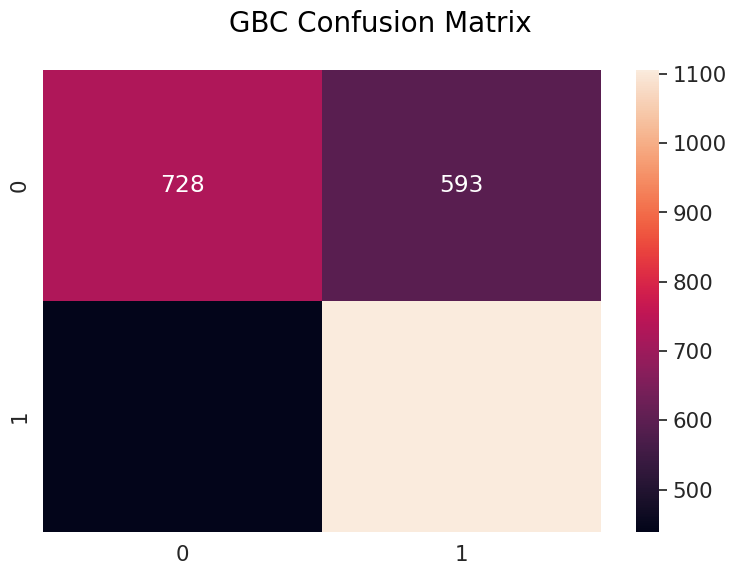

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

# Create a confusion matrix with the validation labels and our model's predictions
conf_matrix = confusion_matrix(y_validation, y_predict)

# Plot confusion matrix
df_conf_matrix = pd.DataFrame(conf_matrix, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (9,6))
plt.suptitle("GBC Confusion Matrix", fontsize=20)
sn.set(font_scale=1.4)
sn.heatmap(df_conf_matrix, annot=True, fmt='g')

### Combine Train and Validation Data for Cross-Validation

In [28]:
# Concatenate the training and validation feature datasets vertically
X_train_and_validation = pd.concat([X_train, X_validation], axis=0).reset_index(drop=True)

# Concatenate the training and validation label datasets vertically
y_train_and_validation = pd.concat([y_train, y_validation], axis=0).reset_index(drop=True)

### K-Fold Cross Validation

Estimate how well the model is likely to generalize to unseen data

In [29]:
from sklearn.model_selection import cross_val_score

# Perform k-fold cross-validation, here with 10 folds
accuracies = cross_val_score(estimator=model, X=X_train_and_validation, y=y_train_and_validation, cv=10)

print("Accuracy is {:.2f}%".format(accuracies.mean()*100))
print("Confidence Interval is +- {:.2f}%\n".format((accuracies.std()*2)*100))
print(accuracies)

Accuracy is 63.25%
Confidence Interval is +- 2.31%

[0.64270761 0.64410328 0.63991626 0.62037683 0.61828332 0.64270761
 0.63756983 0.60963687 0.63128492 0.63826816]


### Feature Significance

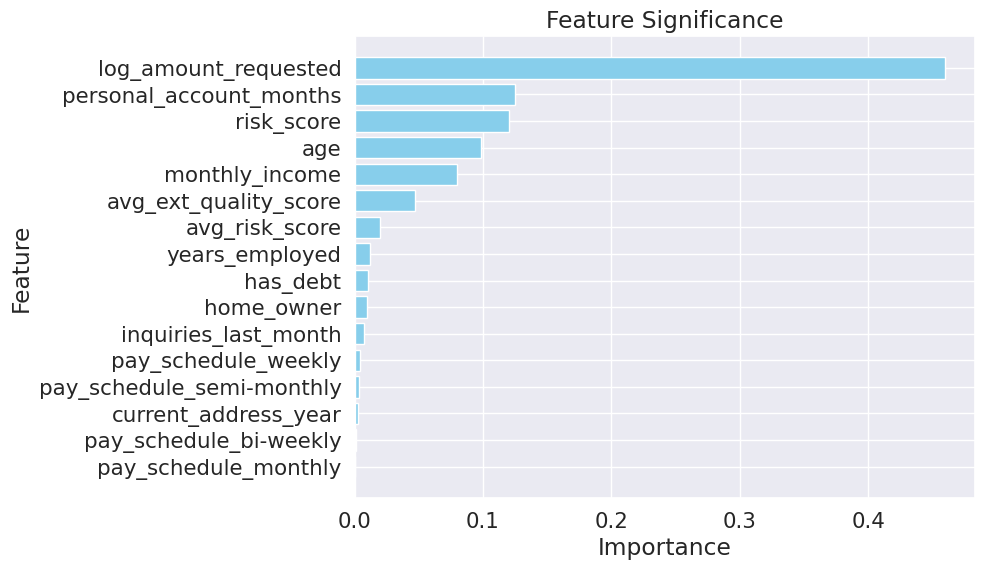

,Feature,Importance
9,log_amount_requested,0.459739
6,personal_account_months,0.124596
4,risk_score,0.120290
0,age,0.098363
1,monthly_income,0.079520
8,avg_ext_quality_score,0.047371
7,avg_risk_score,0.019402
2,years_employed,0.012022
11,has_debt,0.010158
10,home_owner,0.009923


In [30]:
# Extract feature names from the DataFrame
features = X_train.columns.tolist()

# Create a DataFrame with feature names and their importance
feature_df = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
})

# Sort the DataFrame by importance in descending order
feature_df = feature_df.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(8, 6)) 
plt.barh(feature_df['Feature'], feature_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Significance')
plt.gca().invert_yaxis()  # Place highest importantance at top
plt.show()

# Display feature significance numerical values
feature_df

### Receiver Operating Characteristic (ROC) Curve

AUC (Area Under the ROC Curve): 0.70


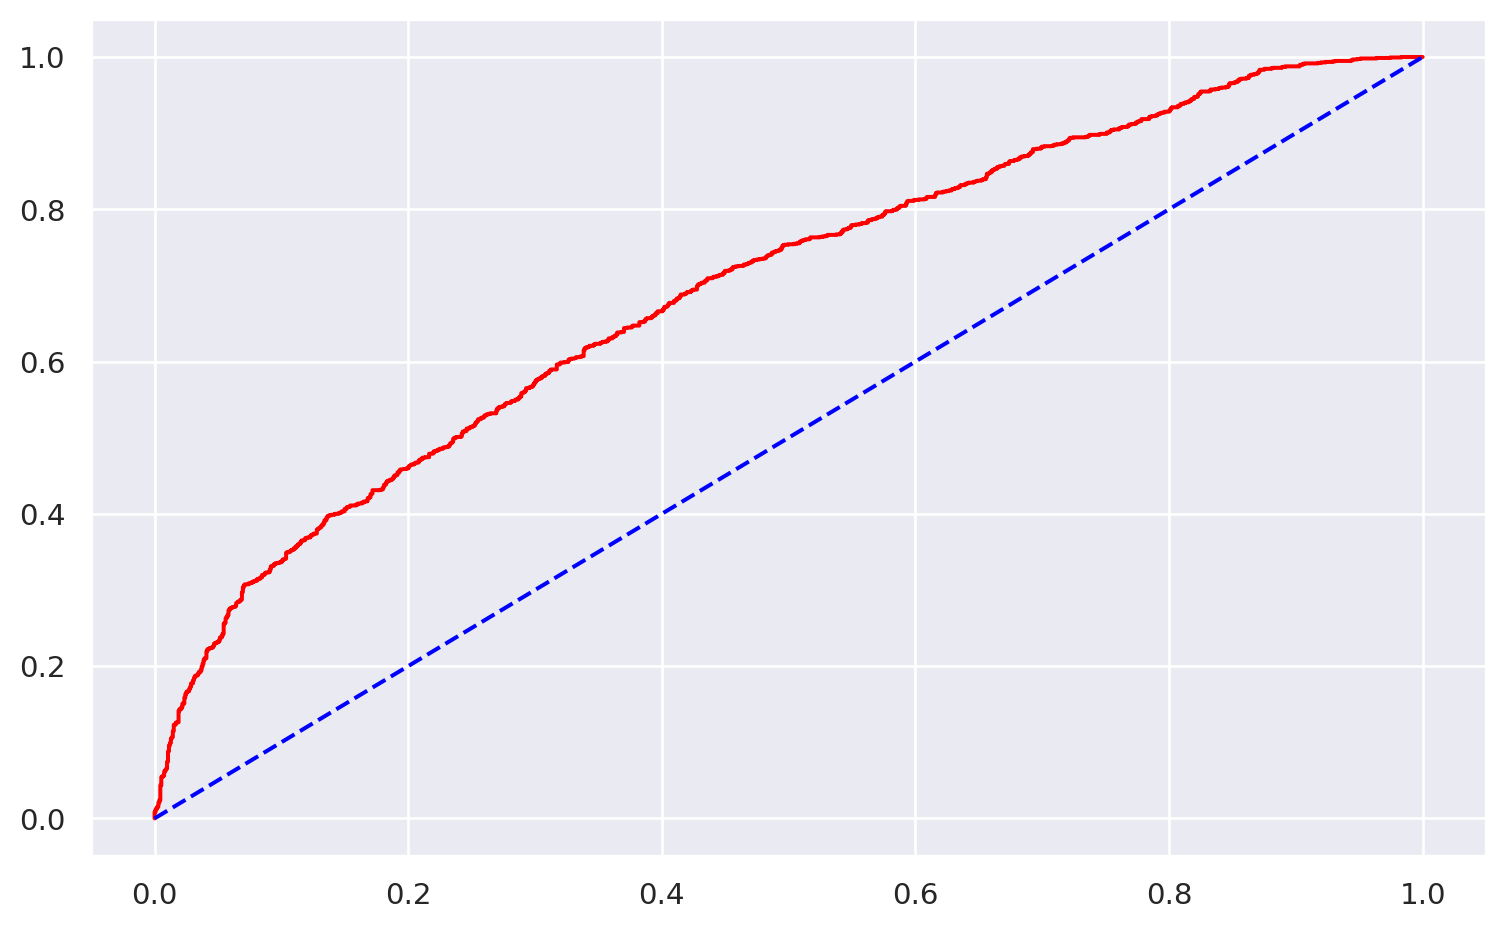

In [32]:
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn.objects as so

# Generate data for a 45 degree line
noskill_probabilities = [0 for number in range(len(y_validation))]

# Predict the probabilities of the positive class
probabilities_posclass = model.predict_proba(X_validation)[:, 1]

# Calculate data for horizontal line
falsepositive_rate_noskill, truepositive_rate_noskill, _ = roc_curve(y_validation, noskill_probabilities)

# Calculate data for ROC curve
falsepositive_rate, truepositive_rate, _ = roc_curve(y_validation, probabilities_posclass)

# Calculate AUC
auc = roc_auc_score(y_validation, probabilities_posclass)

# Display AUC
print("AUC (Area Under the ROC Curve): {:.2f}".format(auc))

# Plot with Seaborn Objects
(so.Plot()
   .add(so.Line(color = 'red'),x =falsepositive_rate, y = truepositive_rate)
   .add(so.Line(color = 'blue',linestyle = 'dashed'),x = falsepositive_rate_noskill, y = truepositive_rate_noskill)
   .layout(size = (8,5))
)

Above we note the model's discriminatory power is considered reasonable

## Model Tuning

Here we utilize Hyperopt for model tuning to take advantage of Bayesian Optimization. We will not be using a Spark cluster so forgo SparkTrials to parallelize trials. 

We begin by initializing MLflow to document our [experiment](../experiments/README.md) 🧪

In [33]:
import mlflow
import os
import random

# Ensure the directory exists
experiment_dir = '../experiments/mlflow_gbc'
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

# Use the directory to save results
mlflow.set_tracking_uri(f'file://{os.path.abspath(experiment_dir)}')

# 5 digit random number for the experiment
random_number = random.randint(10_000, 99_999)

# Set a new experiment
mlflow.set_experiment(f'hyperopt_tuning_{random_number}')

# Fetch experiment details
experiment = mlflow.get_experiment_by_name(f'hyperopt_tuning_{random_number}')

# Display details with the relative path
print(f"<Experiment: artifact_location='file://{experiment_dir}/{experiment.experiment_id}', "
      f"creation_time={experiment.creation_time}, experiment_id='{experiment.experiment_id}', "
      f"last_update_time={experiment.last_update_time}, lifecycle_stage='{experiment.lifecycle_stage}', "
      f"name='{experiment.name}', tags={experiment.tags}>")

2023/10/26 02:58:42 INFO mlflow.tracking.fluent: Experiment with name 'hyperopt_tuning_94418' does not exist. Creating a new experiment.


<Experiment: artifact_location='file://../experiments/mlflow_gbc/735099626877559975', creation_time=1698303522742, experiment_id='735099626877559975', last_update_time=1698303522742, lifecycle_stage='active', name='hyperopt_tuning_94418', tags={}>



- Define the objective function

In [34]:
from hyperopt import STATUS_OK

# Define a variable to keep track of the best model accuracy
best_accuracy_so_far = 0.00

def objective_function(space):
    """
    The objective function for Hyperopt. 
    Accepts the hyperparameter search space & returns the model accuracy. 
    Logs metadata & the model from best trials.
    """
    global best_accuracy_so_far
    
    # Convert floats to integers for the model as needed
    space['n_estimators'] = int(space['n_estimators'])
    space['max_depth'] = int(space['max_depth'])
    space['min_samples_split'] = int(space['min_samples_split'])
    space['min_samples_leaf'] = int(space['min_samples_leaf'])
    
    model = GradientBoostingClassifier(**space, random_state=42)
    
    accuracies = cross_val_score(model, X_train_and_validation, y_train_and_validation, cv = 3)
    
    # Calculate the mean & loss variance from cross validation scores
    accuracy = np.mean(accuracies)
    loss_variance = np.var(accuracies, ddof=1)
    
    # Log metadata & models with MLflow for best trials
    if accuracy > best_accuracy_so_far:
        best_accuracy_so_far = accuracy
        with mlflow.start_run():
            mlflow.log_params(space)
            mlflow.log_metric("accuracy", accuracy)
            mlflow.log_metric("loss_variance", loss_variance)
            mlflow.sklearn.log_model(model, "model")
            mlflow.end_run()
    
    # Here we aim to maximize accuracy, thus return it as a negative value
    return {'loss': -accuracy, 'loss_variance': loss_variance, 'status': STATUS_OK}

- Define the search space

In [35]:
from hyperopt import hp

search_space = {
    'n_estimators': hp.quniform('n_estimators', 150, 350, 10),
    'max_depth': hp.quniform('max_depth', 5, 10, 1),  
    'min_samples_split': hp.quniform('min_samples_split', 5, 15, 1),  
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),  
    'learning_rate': hp.loguniform('learning_rate', np.log(0.02), np.log(0.04)),
    'subsample': hp.uniform('subsample', 0.7, 1.0),
    'max_features': hp.choice('max_features', ['sqrt', 'log2', None]),
}

- Run Hyperopt. _For optimal (or fastest) results, see [suggested formulas](https://www.databricks.com/blog/2021/04/15/how-not-to-tune-your-model-with-hyperopt.html). This will take some time, go have some tea_ 

In [35]:
from hyperopt import fmin, tpe, Trials

num_evals = 105
trials = Trials()

best_hyperparam = fmin(fn=objective_function, 
                       space=search_space, 
                       algo=tpe.suggest, # Bayesian search
                       max_evals=num_evals, 
                       trials=trials, 
                       rstate=np.random.default_rng(42)
                       ) 

print(best_hyperparam)

100%|██████████| 105/105 [38:38<00:00, 22.08s/trial, best loss: -0.6426775237443764]
{'learning_rate': 0.027821122390237863, 'max_depth': 7.0, 'max_features': 2, 'min_samples_leaf': 9.0, 'min_samples_split': 12.0, 'n_estimators': 240.0, 'subsample': 0.9458859821178202}


## Final Model Inference

- Load the model with the best run from MLflow 

In [37]:
import mlflow.sklearn

# Provide the path to directory hosting the experiment (defined above)
mlflow.set_tracking_uri(f'file://{os.path.abspath(experiment_dir)}')

# Provide the experiment id (defined above 'experiment.experiment_id' or insert manually)
experiment_id = '471826949328499785'

# Get the runs from the experiment
runs = mlflow.search_runs(experiment_ids=[experiment_id], filter_string='', max_results=1000)

# Filter the runs for highest accuracy
best_run = runs.sort_values("metrics.accuracy", ascending=False).iloc[0]

# Retrieve the model
best_model_uri = best_run["artifact_uri"] + "/model"
model = mlflow.sklearn.load_model(best_model_uri)

- Train the model

In [38]:
# Train the model on the train & validation data
model.fit(X_train_and_validation, y_train_and_validation)

GradientBoostingClassifier(learning_rate=0.0273666022526306, max_depth=6,
                           min_samples_split=10, n_estimators=350,
                           random_state=42, subsample=0.703030578436894)

- Perform inference

In [39]:
# Make model predictions from the test set
y_predict = model.predict(X_test)

## Final Model Evaluation <iframe src="https://giphy.com/embed/jUQHpQ3UjFBfRlQekP" width="40" height="40" frameBorder="0" class="giphy-embed" allowFullScreen></iframe>

In [40]:
df_final_results = pd.DataFrame()

# Get model scores
df_final_results = evaluate_scores_and_concat(y_test, y_predict, 'Gradient Boosting Classifier (tuned)', df_final_results)

# Display
df_final_results

,Model,Accuracy,Precision,Recall,F1
0,Gradient Boosting Classifier (tuned),0.64852,0.664219,0.703109,0.683111


### Confusion Matrix

<Axes: >

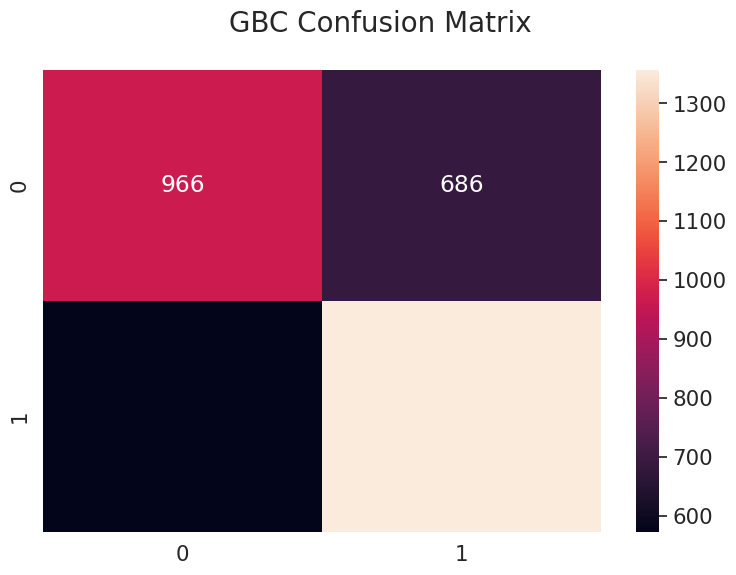

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

# Create a confusion matrix with the validation labels and our model's predictions
conf_matrix = confusion_matrix(y_test, y_predict)

# Plot confusion matrix
df_conf_matrix = pd.DataFrame(conf_matrix, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (9,6))
plt.suptitle("GBC Confusion Matrix", fontsize=20)
sn.set(font_scale=1.4)
sn.heatmap(df_conf_matrix, annot=True, fmt='g')

### Receiver Operating Characteristic (ROC) Curve

AUC (Area Under the ROC Curve): 0.71


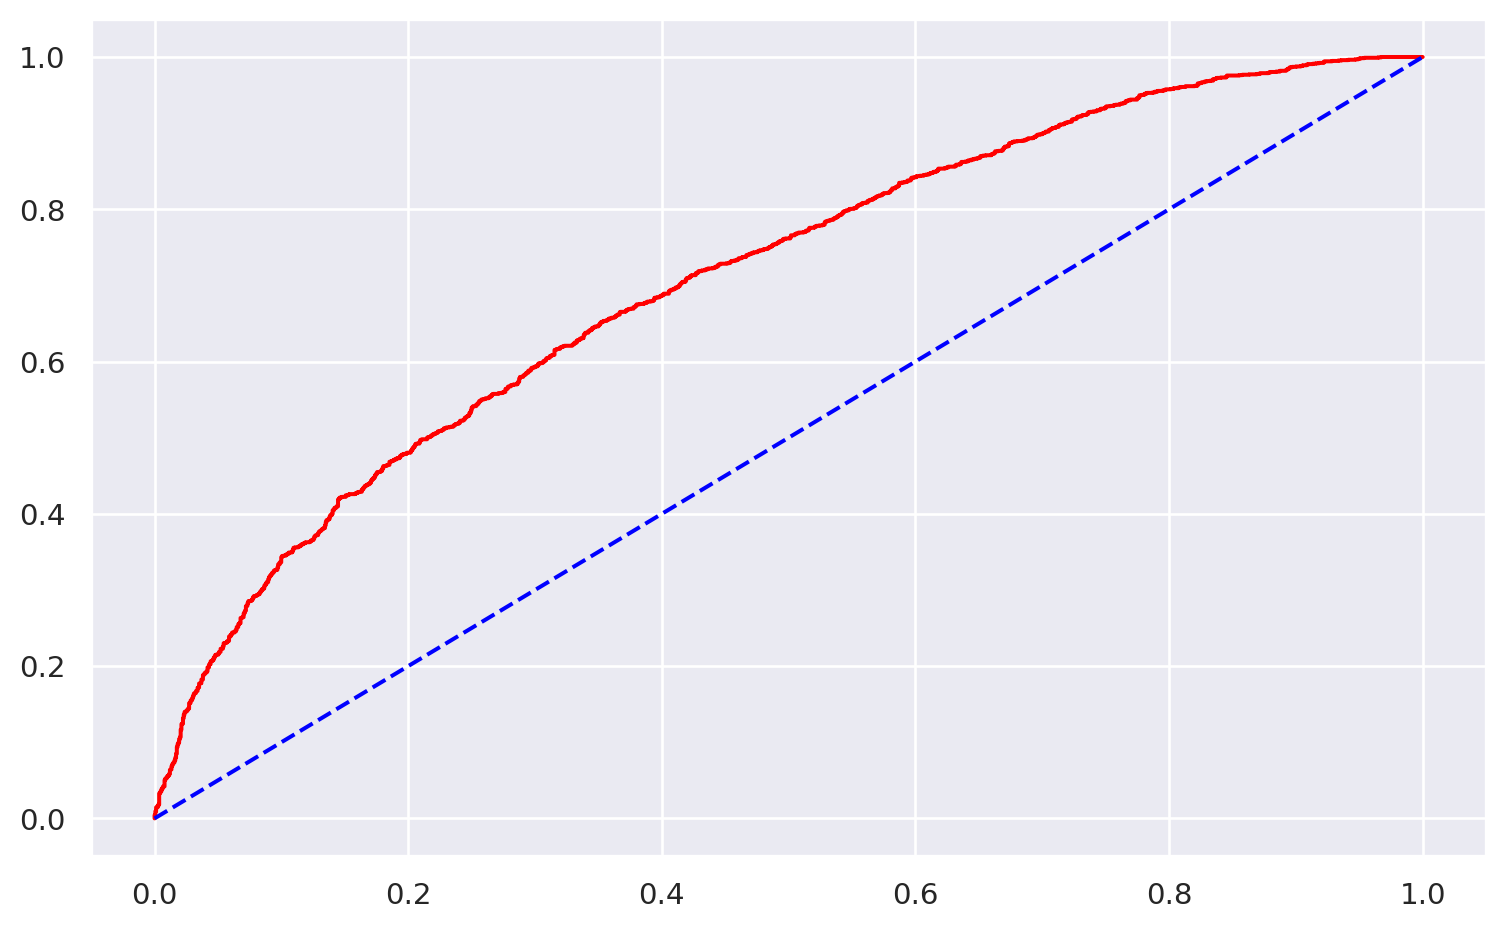

In [42]:
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn.objects as so

# Generate data for a 45 degree line
noskill_probabilities = [0 for number in range(len(y_test))]

# Predict the probabilities of the positive class
probabilities_posclass = model.predict_proba(X_test)[:, 1]

# Calculate data for horizontal line
falsepositive_rate_noskill, truepositive_rate_noskill, _ = roc_curve(y_test, noskill_probabilities)

# Calculate data for ROC curve
falsepositive_rate, truepositive_rate, _ = roc_curve(y_test, probabilities_posclass)

# Calculate AUC
auc = roc_auc_score(y_test, probabilities_posclass)

# Display AUC
print("AUC (Area Under the ROC Curve): {:.2f}".format(auc))

# Plot with Seaborn Objects
(so.Plot()
   .add(so.Line(color = 'red'),x =falsepositive_rate, y = truepositive_rate)
   .add(so.Line(color = 'blue',linestyle = 'dashed'),x = falsepositive_rate_noskill, y = truepositive_rate_noskill)
   .layout(size = (8,5))
)